In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
plt.style.use("paper.mplstyle")
import dicts
from scipy.special import gamma
from scipy.optimize import broyden1
from scipy.interpolate import UnivariateSpline

sd_limits = dicts.sd_limit_dict
sd_anns   = dicts.sd_ann_rate_dict # annihilation rate for xs=1pb

In [2]:
data_path = "/data/user/jlazar/solar_WIMP/data/"

min_exp   = 0.5
max_exp   = 6.5

chs = [5, 8, 11]
ms  = [300,500,1000,3000,5000,10000]

mu_pion         = np.load("%s/e_d_theta_hist/pion_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_pion_bar     = np.load("%s/e_d_theta_hist/pion_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon         = np.load("%s/e_d_theta_hist/kaon_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_kaon_bar     = np.load("%s/e_d_theta_hist/kaon_bar_tot_energy_delta_theta_hist_bg.npy" % data_path)
mu_bg_tot       = mu_pion + mu_pion_bar + mu_kaon + mu_kaon_bar

In [3]:
bb_lims = np.genfromtxt("data/3y_sd_bb_limits.csv", delimiter=",").T
ww_lims = np.genfromtxt("data/3y_sd_ww_limits.csv", delimiter=",").T
tt_lims = np.genfromtxt("data/3y_sd_tt_limits.csv", delimiter=",").T  

lims = [bb_lims, ww_lims, tt_lims]
funcs = {}
for i, ch in enumerate(chs):
    funcs[ch] = UnivariateSpline(np.log10(lims[i][0]), np.log10(lims[i][1]), k=3, s=1e-2)
    
def get_limit(x, ch):
    log10x = np.log10(x)
    return np.power(10, funcs[ch](log10x))

In [4]:
def round_sig_figs(x, sig_figs=2):
    return round(x, sig_figs-int(np.floor(np.log10(abs(x))))-1)

In [5]:
def factorial(x):
    x = np.asarray(x)
    return gamma(x+1)

In [6]:
class poisson():
    
    def __init__(self, mu):
        self.mu      = mu
        self.var     = mu
        self.std     = np.sqrt(mu)
        self.mean    = mu
        self.int_val = quad(self.val, 0, 10*self.std+mu)[0]
    
    def val(self, x):
        return np.exp(-self.mu) * np.power(self.mu, x) / factorial(x)
        
    def pdf(self, x):
        return self.val(x) / self.int_val
    
    def cdf(self, x):
        q = quad(self.pdf, 0, x)
        print(q[1])
        return q[0]

In [7]:
def neg_log_likelihood(mu_s, n_s, mu_b, n_b):
    """
    mu_s float: mean number of signal events
    n_s  int  : observed number of signal events
    mu_b float: mean number of background events
    n_b  int  : observed number of bacground events
    """
    mu = mu_s*n_s + mu_b*n_b
    lh = -np.log(np.exp(-mu) * np.power(mu, mu_b) / factorial(mu_b))
    lh = lh[np.where(~np.isnan(lh))]
    lh = lh[np.where(~np.isinf(lh))]
    return np.sum(lh)

In [8]:
def calc_sens(ch, m, mu_b, tp):
    
    delta_t = 30 * 60
    factor  = (1. / m) * sd_anns[m] * 1e-3 * delta_t
    
    if tp=="reg":
        mu_s = factor * np.load("%s/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist.npy" % (data_path, ch, m)).T
    elif tp=="rescale":
        mu_s = 1.e-4 * factor * np.load("%s/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_rescale.npy" % (data_path, ch, m)).T
    else:
        print("wrongo !!!")
        
    n_b  = 1
    
    yint = 2.71
#     yint = 4.61
    neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_bg_tot, n_b)
    func = lambda n:2*(neg_log_likelihood(mu_s, n, mu_bg_tot, n_b) - neg_log_likelihood_0)-yint
#     arr = [func(n) for n in np.linspace(0,1,1000)]
#     plt.plot(np.linspace(0,1,1000), arr)
#     plt.show()
   
    sens = broyden1(func, 0.5) * 1e-39 # cm^{2}
    return sens

In [9]:
sens_dict          = {ch:{} for ch in chs}
rescaled_sens_dict = {ch:{} for ch in chs}


for m in [300, 500, 1000, 3000, 5000, 10000]:
    for ch in chs:
        sens = calc_sens(ch, m, mu_bg_tot, "reg")
        sens_dict[ch][m] = sens
for m in [300, 500, 1000, 3000, 5000, 10000]:
    for ch in chs:
        sens = calc_sens(ch, m, mu_bg_tot, "rescale")
        rescaled_sens_dict[ch][m] = sens

/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/cvmfs/icecube.opensciencegrid.org/py2-v3/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


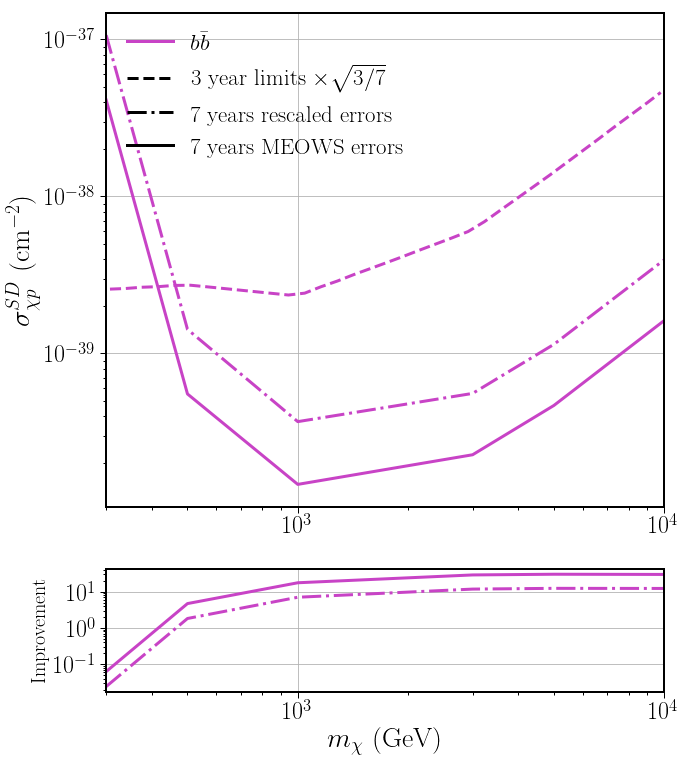

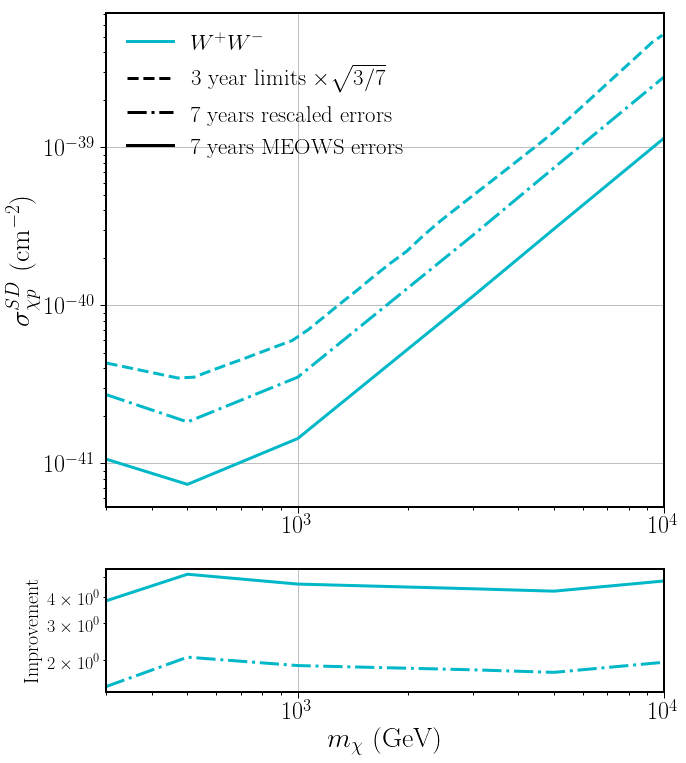

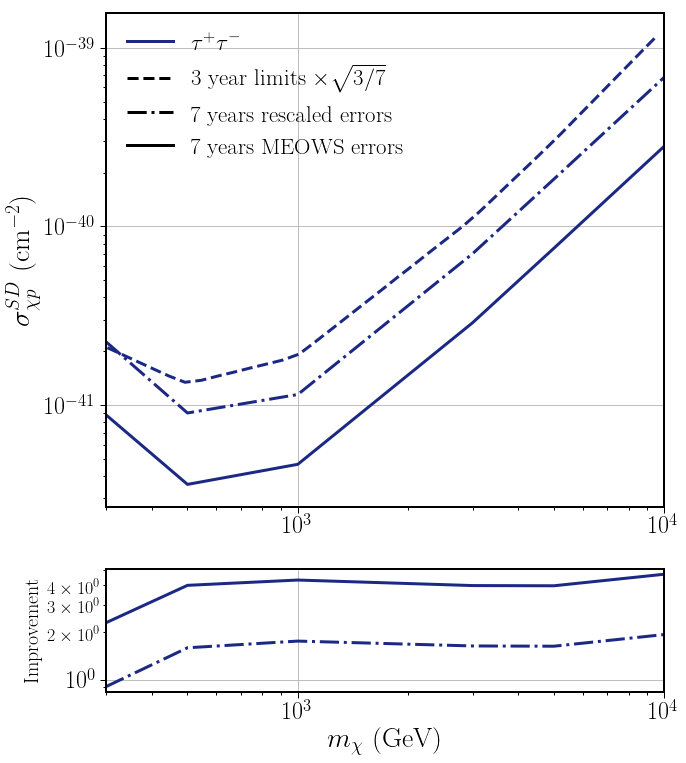

In [11]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# # set up the legend
# legend_elements = []


# fig = plt.figure(figsize=(10,12.5))
# gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
# (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))


# for i, ch in enumerate(chs):
    
   
#     legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
#     ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
#     ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
#     ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    
     
#     ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
#     ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
# #     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
#     ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.")
    

# ax1.set_xlim(300,10000)
# ax2.set_xlim(300,10000)
# ax1.loglog()
# ax2.loglog()
# ax1.grid(which="major")
# ax2.grid()

# ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
# ax2.set_ylabel("Improvement", fontsize=20)
# #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
# ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

# legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
# legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
# legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))


# ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# for tick in ax2.xaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# for tick in ax2.yaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
# [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

# # plt.savefig("plots/stat_only_sensitivity_combined_w_ratio.png")

# plt.show()

scale = np.sqrt(7/3)

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1] / scale, "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch) / scale, sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens) / scale, color=cs[i], linestyle="-.", lw=lw)
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Improvement", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label=r"3 year limits $\times \sqrt{3/7}$", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    
    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_3y_rs_combined_w_ratio.png" % ch)
    
    plt.show()

In [ ]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))


for i, ch in enumerate(chs):
    
   
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], lw=lw)
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.", lw=lw)
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.loglog()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Improvement", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("plots/stat_only_sensitivity_combined_w_ratio.png")

plt.show()

for i, ch in enumerate(chs):
    
    legend_elements = []
    
    fig = plt.figure(figsize=(10,12.5))
    gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
    (ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    
     
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw, linestyle="-.")
#     ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i], linestyle="-.")
    

    ax1.set_xlim(300,10000)
    ax2.set_xlim(300,10000)
    ax1.loglog()
    ax2.loglog()
    ax1.grid(which="major")
    ax2.grid()

    ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
    ax2.set_ylabel("Improvement", fontsize=20)
    #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
    ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

    legend_elements.append(Line2D([0], [0], color="black", label="7 years MEOWS errors", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
    legend_elements.append(Line2D([0], [0], color="black", linestyle="-.", label="7 years rescaled errors", lw=lw))

    ax1.legend(handles=legend_elements, loc='upper left', ncol=1, prop={"size":23}, frameon=False)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    [ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
    [ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

    plt.savefig("plots/ch%d_stat_only_sensitivity_combined_w_ratio.png" % ch)
    
    plt.show()

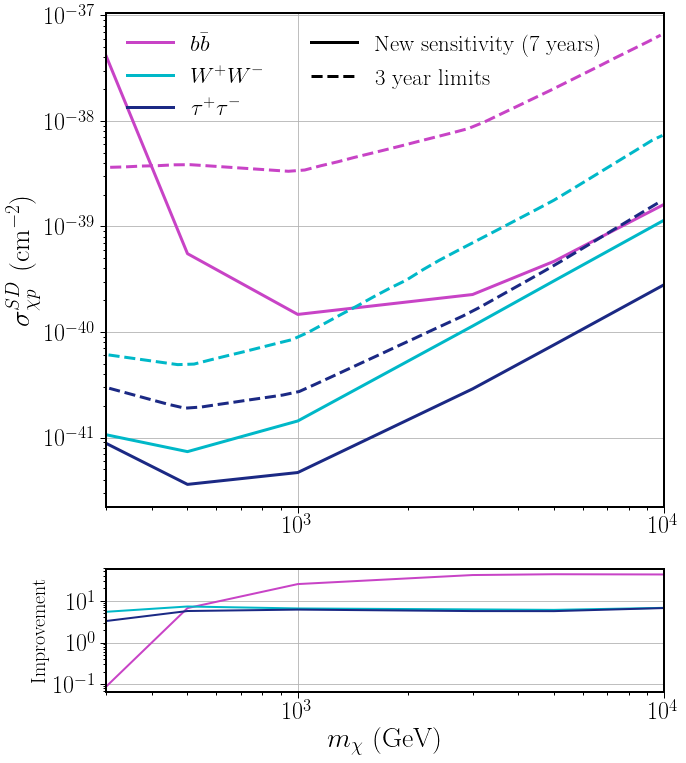

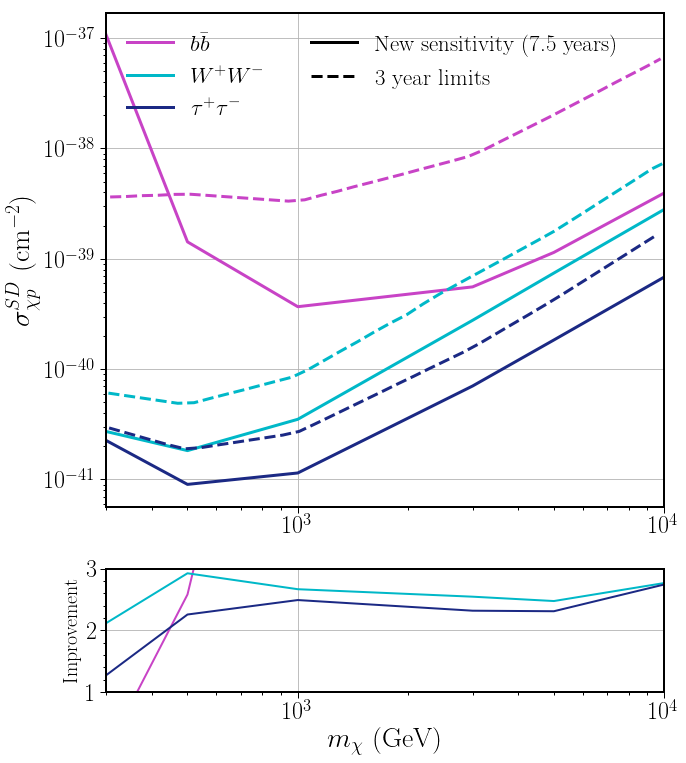

In [12]:
ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
chs = [5, 8, 11]

lw=3
fsize=28

cs = ["#C843C6", "#00B8C8", "#1B2984"]

# set up the legend
legend_elements = []


fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
   
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax1.loglog()
ax2.loglog()
ax1.grid(which="major")
ax2.grid()

ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Improvement", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


legend_elements = []

fig = plt.figure(figsize=(10,12.5))
gs = gridspec.GridSpec (2, 1,height_ratios=[4,1])
(ax1, ax2) = (fig.add_subplot(gs[0]), fig.add_subplot(gs[1]))

for i, ch in enumerate(chs):
    legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
    ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
    ax1.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
    ax1.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
    
    ax2.plot(ms, np.divide(get_limit(ms, ch), sens), color=cs[i])
    

ax1.set_xlim(300,10000)
ax2.set_xlim(300,10000)
ax2.set_ylim(1,3)
ax1.loglog()
# ax2.loglog()
ax2.semilogx()
ax1.grid(which="major")
ax2.grid()
ax1.set_ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
ax2.set_ylabel("Improvement", fontsize=20)
#     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
ax2.set_xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity (7.5 years)", lw=lw))
legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
ax1.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
[ax1.spines[key].set_linewidth(2) for key in ax1.spines.keys()]
[ax2.spines[key].set_linewidth(2) for key in ax2.spines.keys()]

plt.savefig("/data/user/jlazar/solar_WIMP/plots/stat_only_sensitivity_3y_error_w_ratio.png", dpi=400, bbox_inches="tight")
plt.show()


# fig = plt.figure(figsize=(10,10))
# ax  = fig.add_subplot(111)
# for i, ch in enumerate(chs):
#     legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
#     ms, sens = zip(*sorted(rescaled_sens_dict[ch].items())) # unpack a list of pairs into two tuples
#     ax.plot(ms, sens, label=ch_strs[i], color=cs[i], lw=lw)
#     ax.plot(lims[i][0], lims[i][1], "--", color=cs[i], lw=lw)
# plt.xlim(400,10000)
# # plt.semilogy()
# plt.loglog()
# plt.grid(which="major")
# plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
# #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
# plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

# legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
# legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
# ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(24)
# [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
# #     plt.savefig("/Users/jlazar/Documents/IceCube/data/stat_only_sensitivity.png", dpi=400, bbox_inches="tight")
# plt.show()

In [12]:
# def x_intersection(x_arr, y_arr, y_int=0):
#     idx = np.argwhere(np.diff(np.sign(y_arr - np.full(len(y_arr), y_int)))).flatten()
#     return x_arr[idx]

In [13]:
# def calc_scale(ch, m, min_ns=0, max_ns=1, num_ns=10000, add=False):
    
#     ns = np.linspace(min_ns, max_ns, num_ns)
# #     yint = 2.71
#     yint = 4.61
#     l    = num_ns
#     ns   = np.linspace(min_ns, max_ns, l)
#     nb   = 1
#     mu_s = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch, m)).T

#     neg_log_likelihood_0 = neg_log_likelihood(0, mu_s, nb, mu_bg_tot)

#     y = np.array([2*(neg_log_likelihood(ns[i], mu_s, nb, mu_bg_tot) - neg_log_likelihood_0) for i in range(l)])
    
#     scale = x_intersection(ns, y, y_int=yint)[0]
    
#     print(scale)
#     return scale

In [14]:
# def converge_ns(ch, m, thresh=0.0001):
#     num_ns = 10000
#     max_ns = 1
#     min_ns = 0
#     oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#     while oldns==0:
#         oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns * 0.1, num_ns=num_ns)
#         max_ns = max_ns * 0.1
#     while oldns==max_ns:
#         oldns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns * 10, num_ns=num_ns)
#         max_ns = max_ns * 10
#     min_ns = oldns - 0.1
#     max_ns = oldns + 0.1    
#     num_ns = int(1.5 * num_ns)
#     newns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#     err    = np.abs(newns-oldns)/oldns
#     while err > thresh:
#         num_ns = int(1.5 * num_ns)
#         oldns  = newns
#         newns  = calc_scale(ch, m, min_ns=min_ns, max_ns=max_ns, num_ns=num_ns)
#         err    = np.abs(newns-oldns)/oldns
#     print(oldns, newns)
#     if ch==5:
#         scale_dict = bb_scale_dict
#     elif ch==8:
#         scale_dict = ww_scale_dict
#     elif ch==11:
#         scale_dict = tt_scale_dict
#     else:
#         print("Channel must be in [5,8,11]")
#     scales_dict[m] = newns

In [15]:
# def clip_2d_array(arr, clip_i=20):
# #     arr = arr.T
# #     arr = arr[:20]
# #     arr = arr.T
#     return arr[:clip_i]

In [12]:
# def rand_poisson(mu, seed=31093):
#     """
#     return random element drawn from poisson distribution with mean of mu
    
#     mu   float: mean of poisson distributuion to draw from
#     seed int  : seed for random number generator
#     """
#     np.random.seed(seed)
#     dist    = poisson(mu)
#     std_dev = dist.std
#     x       = np.linspace(0, mu + 10*std_dev, 10000000)
#     p       = dist.pdf(x) / np.sum(dist.pdf(x))
#     print(np.sum(p))
#     return np.random.choice(x, p=p)

## Load in signal and background

In [13]:
# def ll_plot(ch, m, min_ns=0, max_ns=1, save=False, show=True, num_ns=10000):
    
#     if ch==5:
#         desc_str = r"$b\bar{b}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==8:
#         desc_str = r"$W^{+}W^{-}$, $m_{\chi}=%d$ GeV" % m
#     elif ch==11:
#         desc_str = r"$\tau^{+}\tau^{-}$, $m_{\chi}=%d$ GeV" % m
#     else:
#         print("Channel must be in [5,8,11]")
    
#     yint = 2.71
#     l    = num_ns
#     ns   = np.linspace(min_ns, max_ns, l)
#     nb   = 1
#     mu_s = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch, m)).T

#     neg_log_likelihood_0 = neg_log_likelihood(mu_s, 0, mu_bg_tot, nb)

#     y = np.array([2*(neg_log_likelihood(mu_s, ns[i], mu_bg_tot, nb) - neg_log_likelihood_0) for i in range(l)])
#     ymax = max(y)
    
#     xint = x_intersection(ns, y, y_int=yint)[0]

#     plt.plot(ns, y)
#     print(min_ns)
#     print(xint / (max_ns+min_ns))
#     plt.axhline(y=yint, xmin=0, xmax=(xint-min_ns) / (max_ns-min_ns))
#     plt.axvline(x=xint, ymin=0, ymax=yint / ymax)
#     plt.text(xint, 0, r"$n_{s}=%s$" % str(round_sig_figs(xint, sig_figs=3)))
#     plt.plot(xint, yint, 'ro')

#     plt.ylabel(r"$-2\Delta LLH$")
#     plt.xlabel(r"$n_{s}$")
#     plt.title(desc_str)
    
#     plt.ylim(0, ymax)
#     plt.xlim(min_ns, max_ns)

#     plt.grid()

# #     ticks, labels = plt.xticks()
# #     ticks = np.append(ticks, [xint])
# #     plt.xticks(ticks)

#     if save:
#         plt.savefig("/Users/jlazar/Documents/IceCube/ch%d_m%d_lh.png" % (ch, m))
    
#     if show:
#         plt.show()
#     print(xint)

In [8]:


# cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', "gnuplot2"]

# ms = [400,500,1000,3000,5000,10000]
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)
# for c in cmaps:
    
#     cmap       = plt.get_cmap(c)
#     c_norm     = colors.Normalize(vmin=0, vmax=n_chans)
#     scalar_map = cm.ScalarMappable(norm=c_norm, cmap=cmap)
#     cs         = [scalar_map.to_rgba(i) for i in range(n_chans)][::-1]

#     old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#                 np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#                 np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#                ]
    
#     # set up the legend
#     legend_elements = []
    
                  
    
    
#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))
        
#         ax.plot(ms, [sd_limits[ch][m]*scales[ch][m]*1.e-36 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(500,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
# #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)
    
#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":24}, frameon=False)
    
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()

In [9]:
# ms = [400,500,800,1000,3000,5000,10000]
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)

# colors   = [["#00B8C8", "#C843C6", "#1B2984"],
#             ["#C843C6", "#00B8C8", "#1B2984"]
#            ]

# old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#            ]
# for cs in colors:
#     # set up the legend
#     legend_elements = []




#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))

#         ax.plot(ms, [sd_limits[ch][m]*scales_dict[ch][m]*1.e-36 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(500,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
#     #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()

In [22]:
# for m in [400, 800,]:
#     for ch in chs:
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m), frown*1e-3)
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_tot_e_d_theta_hist_course.npy" % (ch,m), frown*1e-3)
#         frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_bar_e_d_theta_hist_course.npy" % (ch,m))
#         np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/ch%d_m%d_nu_bar_e_d_theta_hist_course.npy" %(ch,m), frown*1.e-3)
#         for nt in ["nu","nuBar"]:
#             for i in range(100):
#                 frown = np.load("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/partial_hists/ch%d_m%d_%s_%d_energy_delta_theta_hist_course.npy" %(ch,m,nt,i))
#                 np.save("/Users/jlazar/Documents/IceCube/data/e_d_theta_hist/partial_hists/ch%d_m%d_%s_%d_energy_delta_theta_hist_course.npy" %(ch,m,nt,i), frown*1.e-3)    

In [18]:
# ch_strs = [r"$b\bar{b}$", r"$W^{+}W^{-}$", r"$\tau^{+}\tau^{-}$"]
# chs = [5, 8, 11]
# # colors = ["#2200FF", "#008000", "#FF0000"]

# lw=3
# fsize=28

# n_chans    = len(chs)

# colors   = [["#00B8C8", "#C843C6", "#1B2984"],
#             ["#C843C6", "#00B8C8", "#1B2984"]
#            ]

# old_lims = [np.genfromtxt("/Users/jlazar/Downloads/3y_sd_bb_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_ww_limits.csv", delimiter=",").T,
#             np.genfromtxt("/Users/jlazar/Downloads/3y_sd_tt_limits.csv", delimiter=",").T
#            ]
# for cs in colors:
#     # set up the legend
#     legend_elements = []




#     fig = plt.figure(figsize=(10,10))
#     ax  = fig.add_subplot(111)

#     for i, ch in enumerate(chs):
#         legend_elements.append(Line2D([0], [0], color=cs[i], label=ch_strs[i], lw=3))

#         ax.plot(ms, [scale_dict[ch][m]*1.e-39 for m in ms], label=ch_strs[i], color=cs[i], lw=lw)
#         ax.plot(old_lims[i][0], old_lims[i][1], "--", color=cs[i], lw=lw)
#     plt.xlim(400,10000)
#     # plt.semilogy()
#     plt.loglog()
#     plt.grid(which="major")
#     plt.ylabel(r"$\sigma_{\chi p}^{SD}$ (cm$^{-2}$)", fontsize=fsize)
#     #     plt.ylabel(r"$\sigma_{\chi p}^{SD} \left(\rm{cm}^{-2}\right)$", fontsize=fsize)
#     plt.xlabel(r"$m_{\chi}$ (GeV)", fontsize=fsize)

#     legend_elements.append(Line2D([0], [0], color="black", label="New sensitivity", lw=lw))
#     legend_elements.append(Line2D([0], [0], color="black", linestyle="--", label="3 year limits", lw=lw))
#     ax.legend(handles=legend_elements, loc='upper left', ncol=2, prop={"size":23}, frameon=False)

#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(24)
#     [ax.spines[key].set_linewidth(2) for key in ax.spines.keys()]
#     plt.show()